Harmonic analysis using the Frequency sweep Krylov method
===================================================

This example shows how to use the krylov method in Pymapdl for harmonic analysis.

How to use the methods:

*  Krygensub to generate a Krylov subspace for model reduction in harmonic analysis
*  Krysolve to reduces system of equations and solve at each frequency.
*  Kryexpand to expand reduced solution back to FE space.

Problem Description
------------------------------ 

To perform Harmonic analysis on a cylindrical acoustic duct using the Krylov method and
study the response of the system over a range of frequencies.

The model is a cylindrical acoustic duct with pressure load on one end and output impedance on other end. </span>

In [19]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from ansys.mapdl.core import launch_mapdl

Launch mapdl in '-smp' mode

In [2]:
mapdl = launch_mapdl(additional_switches='-smp',nproc=4)
mapdl.clear()
mm = mapdl.math

Define Geometry Details

In [3]:
pi = np.arccos(-1)
rho = 1.2                        # density
c0 = 340                         # Speed of Sound
frq = 1000                       # excitation freq   Hz
visco = 0.9                      # viscosity

TP = 1/frq
WL = c0 * TP
no_wl = 3                        # no of wavelengths in space

cyl_L = no_wl * WL               # length of duct
cyl_r = 0.025 * cyl_L            # cross section of duct

nelem_wl = 10                    # no of elements per wavelength
tol_elem = nelem_wl * no_wl

Element & Material definition

In [4]:
mapdl.prep7()

mapdl.et(1,'FLUID220', kop2=1)   # Uncoupled acoustic element without FSIs
mapdl.mp("DENS", 1, rho)
mapdl.mp("SONC", 1, c0)
mapdl.mp("VISC", 1, visco)

MATERIAL          1     VISC =  0.9000000

Geometry creation

In [5]:
mapdl.allsel()
mapdl.csys(0)
mapdl.wpcsys(-1)
mapdl.wprota(thzx=90)
mapdl.asel('NONE')
mapdl.vsel('NONE')
mapdl.cyl4(0, 0, cyl_r)
mapdl.wpcsys(-1)
mapdl.vext("ALL", dx=cyl_L)
mapdl.vsbw("ALL", keep='DELETE')
mapdl.wprota(thzx=90)
mapdl.vsbw("ALL", keep='DELETE')
mapdl.wpcsys(-1)
mapdl.cm('cm1', 'volu')

DEFINITION OF COMPONENT = CM1       ENTITY=VOLU

Mesh Creation

In [6]:
mapdl.mat(1)
mapdl.type(1)
mapdl.cmsel("S", "cm1")
mapdl.aslv()
mapdl.lsla()
mapdl.lsel("U", 'loc', 'x', 0)
mapdl.lsel("U", 'loc', 'x', cyl_L)
mapdl.lesize('ALL',ndiv = tol_elem)
mapdl.lsla()
mapdl.vsweep('ALL')
mapdl.allsel()

SELECT ALL ENTITIES OF TYPE= ALL  AND BELOW

Plot FE model :

c:\python38\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


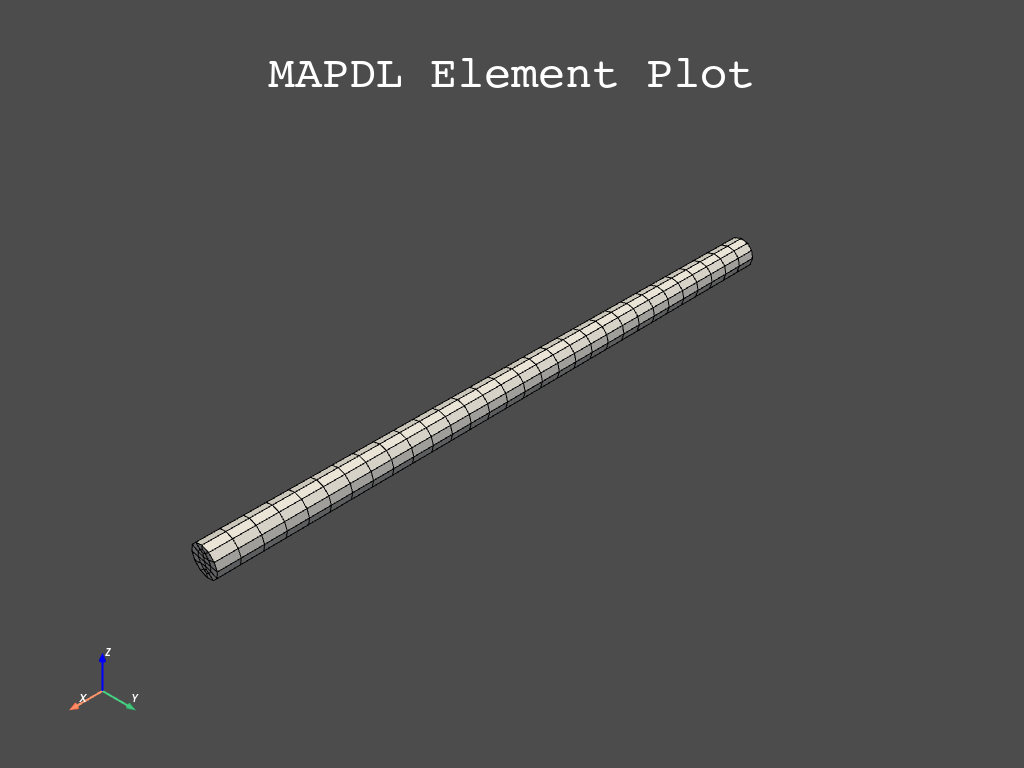

In [7]:
mapdl.eplot()

Define Load & Boundary Condition

In [8]:
mapdl.cmsel("S", "cm1")
mapdl.aslv()
mapdl.asel('R',"EXT")
mapdl.asel('R',"LOC","x",0)
mapdl.nsla('S',1)   
mapdl.d('ALL','PRES', 1)
mapdl.cmsel("S", "cm1")
mapdl.aslv()
mapdl.asel('R',"EXT")
mapdl.asel('R',"LOC","x",cyl_L)
mapdl.nsla("S",1)      
mapdl.sf("ALL","IMPD",1000)
mapdl.allsel()

SELECT ALL ENTITIES OF TYPE= ALL  AND BELOW

Perform Modal Analysis to study the natural modes of the system
---------------------------------------------------------------------------------------------

In [9]:
# Modal Analysis
mapdl.run("/SOLU")
nev = 10 # Get the first 10 modes
output = mapdl.modal_analysis("DAMP", nmode=nev)
mapdl.finish()
mm.free()
k = mm.stiff(fname=f"{mapdl.jobname}.full")
M = mm.mass(fname=f"{mapdl.jobname}.full")
A = mm.mat(k.nrow, nev)
ev = mm.eigs(nev, k, M, phi=A, fmin=1.0)
for i in range(nev):
    f = ev[i]  # Eigenfrequency (Hz)
    print(f"[{i}] : Freq = {f:8.2f} Hz")

[0] : Freq =    83.33 Hz
[1] : Freq =   250.00 Hz
[2] : Freq =   416.67 Hz
[3] : Freq =   583.34 Hz
[4] : Freq =   750.03 Hz
[5] : Freq =   916.74 Hz
[6] : Freq =  1083.49 Hz
[7] : Freq =  1250.32 Hz
[8] : Freq =  1417.26 Hz
[9] : Freq =  1584.36 Hz


Run Harmonic Analysis using Krylov method
-----------------------------------------------------------------
Step 1 : Generate Full File

In [10]:
# mapdl.run('/SOLU')
mapdl.antype('HARMIC')  # HARMONIC ANALYSIS
mapdl.hropt('KRYLOV')
mapdl.eqslv('SPARSE')
mapdl.harfrq(0,1000)   # Set beginning and ending frequency
mapdl.nsubst(100)      # Set the number of frequency increments
mapdl.wrfull(1)        # GENERATE .FULL FILE AND STOP
output = mapdl.solve()
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         4.422

Initialize Krylov class object

In [11]:
dd = mapdl.krylov

Step 2 : Generate a Krylov subspace of size / Dimension 10 at frequency 500 Hz for model reduction

In [12]:
Qz = dd.krygensub(10, 500, True, True)

In [13]:
# The shape of the Subspace generated
print(Qz.shape)

(3240, 10)


Step 3 : Reduces system of equations and solve at each frequency
Solve from 0 Hz to 1000 Hz with ramped loading

In [14]:
Yz = dd.krysolve(0, 1000, 100, 0, True)

In [15]:
# Reduced solution over Frequency range
print(Yz.shape)

(10, 100)


Step 4 : Expand reduced solution back to FE space

In [16]:
res = dd.kryexpand(True, 3)

Results : Pressure Distribution as a function of length
-----------------------------------------------------------------------------

In [17]:
# Select all nodes with Z and Y coordinate 0
mapdl.nsel("S", "LOC", "Z", 0)
mapdl.nsel("R", "LOC", "Y", 0)
mapdl.cm("node_comp", "NODES")
comp = mapdl.cmsel("S", "node_comp")
nodes = mapdl.db.nodes
ind, coords, angles = nodes.all_asarray()

In [20]:
# Load last substep results
# Get Pressure for each of the selected nodes
x_data = []
y_data = []
substep_index = 99
for each_node, loc in zip(ind, coords):
    index_num = np.where(res[substep_index]['node'] == each_node)
    pressure = res[substep_index][index_num]['x'][0]
    #Calculate amplitude at 60 deg
    magnitude = abs(pressure)
    phase = math.atan2(pressure.imag,pressure.real)
    pressure_a = magnitude * np.cos(np.deg2rad(60)+phase)
    x_data.append(loc[0])
    y_data.append(pressure_a)

In [21]:
# Sort the results according to X-coord min to X-coord max
sorted_x_data, sorted_y_data = zip(*sorted(zip(x_data, y_data)))

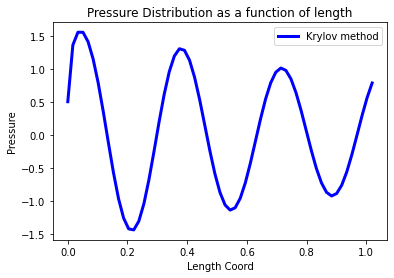

In [22]:
# Plotting the curve
plt.plot(sorted_x_data, sorted_y_data, linewidth= 3.0, color='b', label='Krylov method')
  
# Naming the x-axis, y-axis and the whole graph
plt.title("Pressure Distribution as a function of length")
plt.xlabel("Length Coord")
plt.ylabel("Pressure")
  
# Adding legend
plt.legend()
  
# To load the display window
plt.show()

Results : Plot Frequency response Function
---------------------------------------------------------------

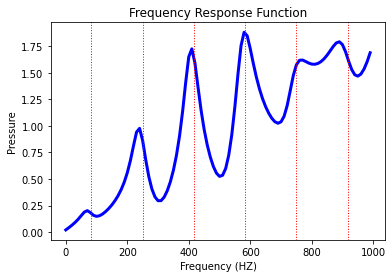

In [23]:
# Pick node closest to 0.2 in X direction, Y&Z = 0
node_number = mapdl.queries.node(0.2, 0, 0)

# Get the response of the system for the selected node
# over a range of frequency [0-1000 Hz]
start_freq = 0
end_freq = 1000
num_steps = 100
step_val = (end_freq - start_freq) / num_steps
dic = {}
for freq in range (0,num_steps):
    index_num = np.where(res[freq]['node'] == node_number)
    pressure = res[freq][index_num]['x']
    abs_pressure = abs(pressure)
    dic[start_freq] = abs_pressure
    start_freq += step_val

    
frf_List = dic.items()
frf_List = sorted(frf_List)
frf_x, frf_y = zip(*frf_List) 
    
# Plotting the curve    
plt.plot(frf_x, frf_y, linewidth= 3.0, color='b')

#Plot the natural frequency as vertical lines on the FRF graph
for itr in range(0,6):
    plt.axvline(x=ev[itr], ymin=0,ymax=2, color='r', linestyle='dotted', linewidth=1)
    
# Naming the x-axis, y-axis and the whole graph
plt.title("Frequency Response Function")
plt.xlabel("Frequency (HZ)")
plt.ylabel("Pressure")

# To load the display window
plt.show()
